In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.7")
!python -m pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 612kB/s 
     |████████████████████████████████| 2.2MB 22.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201212-cp36-none-any.whl size=40319 sha256=aa82d7977343d231d065f5aace9b16d5ed815c2e97214647742da5ddde955212
  Stored in directory: /root/.cache/pip/wheels/6e/2e/c5/d6630ee25d853108402a21c7c2dbaf666d450a7b70cdc7eb49
  Created wheel for iopath: filename=iopath-0.1.2-cp36-none-any.whl size=10505 sha256=8b1f89cf28b8794f02da7ae002e7368ce6bc7ff1a86eba358dbb74c3b0c932c2
  Stored in directory: /root/.cache/pip/wheels/9e/01/e4/1b68f5a2a6b9450ea4246d91840a77e1169f7d4722d76bbc47
Successfully built fvcore iopath
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from cv2 import imshow

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [ ]:
import glob
from fvcore.common.file_io import PathManager
import xml.etree.ElementTree as ET
from detectron2.structures import BoxMode

In [ ]:
!unzip "/content/Dove pascal.zip"

Archive:  /content/Dove pascal.zip
   creating: Dove pascal/
   creating: Dove pascal/Train/
  inflating: Dove pascal/Train/annotate1.jpg  
  inflating: Dove pascal/Train/IMG-20201008-WA0000.jpg  
  inflating: Dove pascal/Train/IMG-20201008-WA0001.jpg  
  inflating: Dove pascal/Train/IMG-20201008-WA0003.jpg  
  inflating: Dove pascal/Train/IMG-20201008-WA0005.jpg  
  inflating: Dove pascal/Train/IMG-20201008-WA0006.jpg  
  inflating: Dove pascal/Train/IMG-20201008-WA0007.jpg  
  inflating: Dove pascal/Train/IMG-20201008-WA0009.jpg  
  inflating: Dove pascal/Train/IMG-20201008-WA0011.jpg  
  inflating: Dove pascal/Train/IMG-20201008-WA0012.jpg  
  inflating: Dove pascal/Train/IMG-20201008-WA0013.jpg  
  inflating: Dove pascal/Train/IMG-20201008-WA0015.jpg  
  inflating: Dove pascal/Train/IMG-20201008-WA0016.jpg  
  inflating: Dove pascal/Train/IMG-20201008-WA0017.jpg  
  inflating: Dove pascal/Train/IMG-20201008-WA0018.jpg  
  inflating: Dove pascal/Train/IMG-20201008-WA0019.jpg  
  inf

In [ ]:
basedir='/content/Dove pascal/'

In [ ]:
## Loader for Custom Dataset.. Format not same as PASCAL VOC

In [ ]:
class_names=['Dove']

In [ ]:
def load_data(imgdir):
    print(imgdir)
    files = glob.glob("{}/*.xml".format(imgdir))
    dicts = []
    for fname in files:
        # print(fname)
        anno_file = fname
        jpeg_file = fname[:-3]+"jpg"
        if not os.path.exists(jpeg_file):
            jpeg_file=jpeg_file[:-3]+"jpeg"
        with PathManager.open(anno_file) as f:
            tree = ET.parse(f)
        r = {
            "file_name": jpeg_file,
#             "image_id": fileid,
            "height": int(tree.findall("./size/height")[0].text),
            "width": int(tree.findall("./size/width")[0].text),
        }
        instances = []
        for obj in tree.findall("object"):
            cls = obj.find("name").text
            if cls=='shampoo':
                cls='Shampoo'
            # We include "difficult" samples in training.
            # Based on limited experiments, they don't hurt accuracy.
            # difficult = int(obj.find("difficult").text)
            # if difficult == 1:
            # continue
            bbox = obj.find("bndbox")
            bbox = [float(bbox.find(x).text) for x in ["xmin", "ymin", "xmax", "ymax"]]
            # Original annotations are integers in the range [1, W or H]
            # Assuming they mean 1-based pixel indices (inclusive),
            # a box with annotation (xmin=1, xmax=W) covers the whole image.
            # In coordinate space this is represented by (xmin=0, xmax=W)
            bbox[0] -= 1.0
            bbox[1] -= 1.0
            instances.append(
                {"category_id": class_names.index(cls), "bbox": bbox, "bbox_mode": BoxMode.XYXY_ABS}
            )
        r["annotations"] = instances
        dicts.append(r)
    return dicts

In [ ]:
# dataset_dicts = load_data(basedir+"Train")

In [ ]:
# dataset_dicts

In [ ]:
for d in ["Train", "Test"]:
    DatasetCatalog.register("shampoo_" + d, lambda d=d: load_data(basedir+ d))
    MetadataCatalog.get("shampoo_" + d).set(thing_classes=['dove'])
shampoo_metadata = MetadataCatalog.get("shampoo_Train")

In [ ]:
shampoo_metadata

Metadata(name='shampoo_Train', thing_classes=['dove'])

In [ ]:
# dataset_dicts

In [ ]:
#Visualizing the Train Dataset
dataset_dicts = load_data(basedir+'Train/')
#Randomly choosing 3 images from the Set
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=shampoo_metadata)
    vis = visualizer.draw_dataset_dict(d)
#     imshow('',vis.get_image()[:, :, ::-1])
#     cv2.waitKey(1)

/content/Dove pascal/Train/


In [ ]:
# dataset_dicts

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) #Get the basic model configuration from the model zoo 
#Passing the Train and Validation sets
cfg.DATASETS.TRAIN = ("shampoo_Train",)
cfg.DATASETS.TEST = ("shampoo_Test",)
# Number of data loading threads
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
# Number of images per batch across all machines.
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.0125  # pick a good LearningRate
cfg.SOLVER.MAX_ITER = 500  #No. of iterations   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # No. of classes = [HINDI, ENGLISH, OTHER]
cfg.TEST.EVAL_PERIOD = 500 # No. of iterations after which the Validation Set is evaluated. 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/12 17:47:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[12/12 17:47:34 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[12/12 17:47:40 d2.utils.events]:  eta: 0:01:51  iter: 19  total_loss: 1.626  loss_cls: 0.5616  loss_box_reg: 0.1828  loss_rpn_cls: 0.3161  loss_rpn_loc: 0.1721  time: 0.2216  data_time: 0.0234  lr: 0.00024976  max_mem: 1573M
[12/12 17:47:44 d2.utils.events]:  eta: 0:01:46  iter: 39  total_loss: 1.343  loss_cls: 0.4172  loss_box_reg: 0.7535  loss_rpn_cls: 0.1032  loss_rpn_loc: 0.09162  time: 0.2292  data_time: 0.0025  lr: 0.00049951  max_mem: 1573M
[12/12 17:47:49 d2.utils.events]:  eta: 0:01:42  iter: 59  total_loss: 1.083  loss_cls: 0.2416  loss_box_reg: 0.6908  loss_rpn_cls: 0.0364  loss_rpn_loc: 0.08035  time: 0.2295  data_time: 0.0025  lr: 0.00074926  max_mem: 1573M
[12/12 17:47:54 d2.utils.events]:  eta: 0:01:37  iter: 79  total_loss: 0.8181  loss_cls: 0.1852  loss_box_reg: 0.5648  loss_rpn_cls: 0.01943  loss_rpn_loc: 0.0877  time: 0.2298  data_time: 0.0023  lr: 0.00099901  max_mem: 1573M
[12/12 17:47:58 d2.utils.events]:  eta: 0:01:33  iter: 99  total_loss: 0.7423  loss_cls: 0.1

In [ ]:
from google.colab.patches import cv2_imshow

/content/Dove pascal/Test


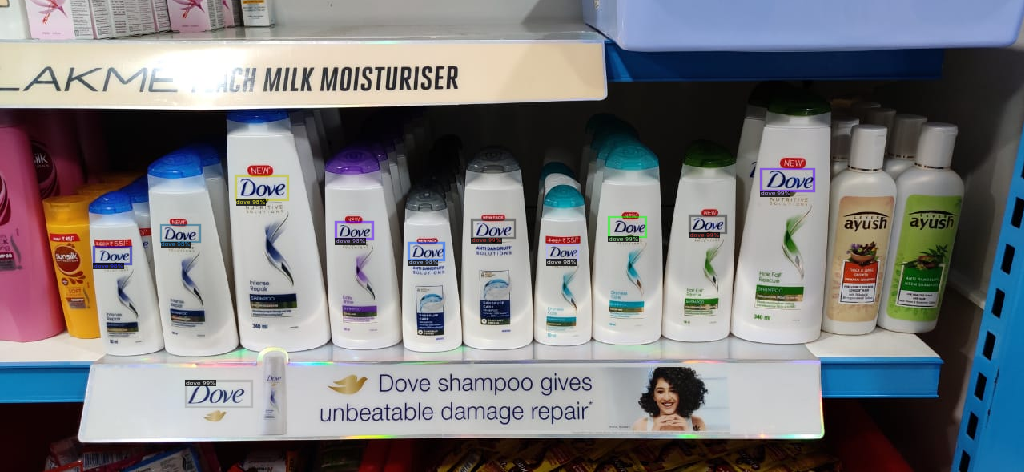

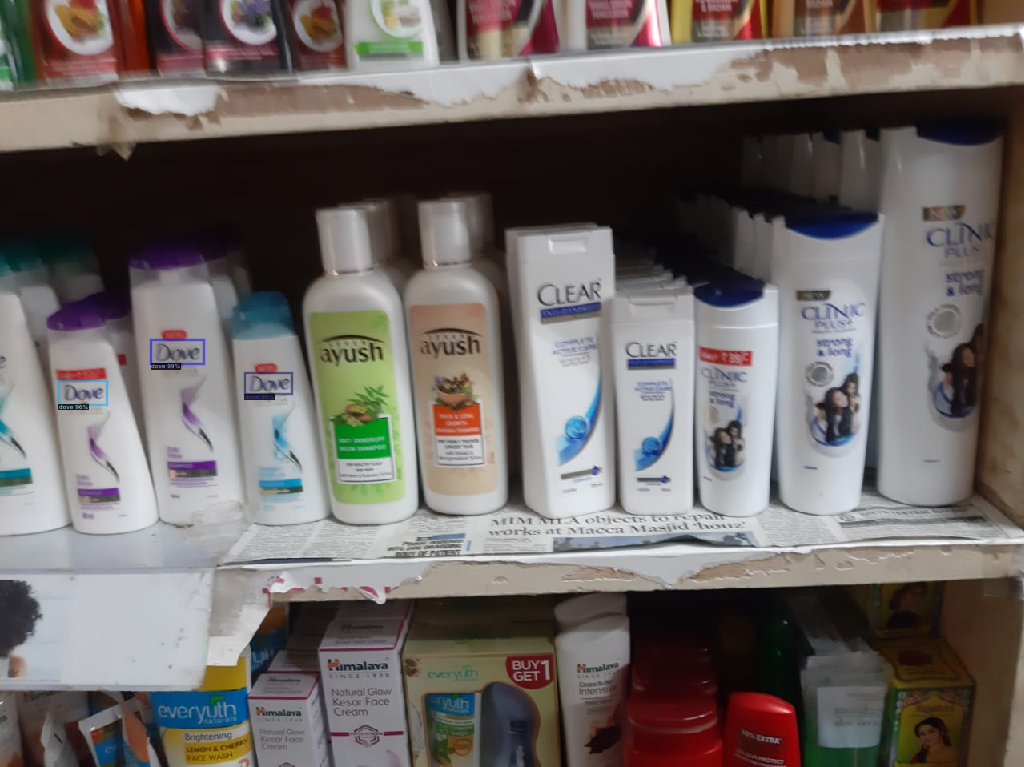

In [ ]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("shampoo_Test", )

predictor = DefaultPredictor(cfg)

dataset_dicts = load_data(basedir+"Test")
for d in random.sample(dataset_dicts, 2):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=shampoo_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
    cv2_imshow(v.get_image()[:, :, ::-1])


In [ ]:
!wget -O testimage.jpg "https://brandyuva.in/wp-content/uploads/2018/10/best-shampoo-brands.jpg"

--2020-12-12 17:52:48--  https://brandyuva.in/wp-content/uploads/2018/10/best-shampoo-brands.jpg
Resolving brandyuva.in (brandyuva.in)... 104.28.18.38, 104.28.19.38, 172.67.130.95, ...
Connecting to brandyuva.in (brandyuva.in)|104.28.18.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25707 (25K) [image/jpeg]
Saving to: ‘testimage.jpg’

testimage.jpg       100%[===================>]  25.10K  --.-KB/s    in 0s      

2020-12-12 17:52:49 (116 MB/s) - ‘testimage.jpg’ saved [25707/25707]



In [ ]:
im = cv2.imread("/content/testimage.jpg")

outputs = predictor(im)

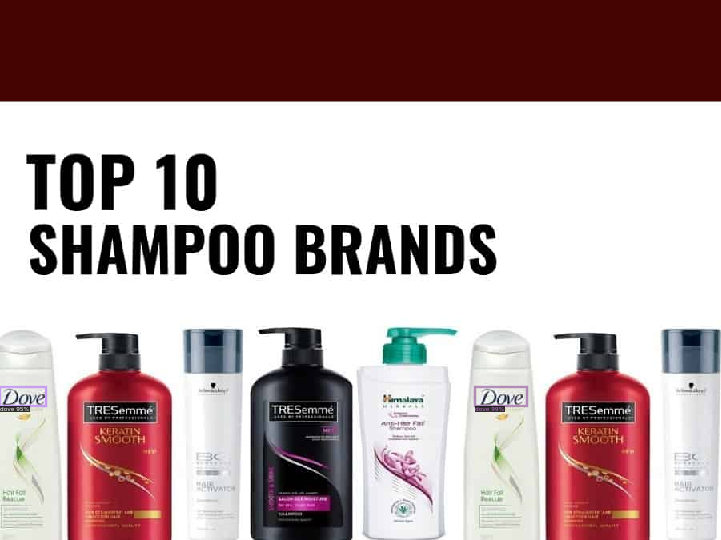

In [ ]:
v = Visualizer(im[:, :, ::-1],
                   metadata=shampoo_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
cv2_imshow(v.get_image()[:, :, ::-1])


In [ ]:
!unzip "/content/TEST.zip"

In [ ]:
for imgs in os.listdir('/content/TEST'):    
    im = cv2.imread(os.path.join('/content/TEST',imgs))
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=shampoo_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
    cv2_imshow(v.get_image()[:, :, ::-1])


In [ ]:
!zip -r output.zip "/content/output"

  adding: content/output/ (stored 0%)
  adding: content/output/events.out.tfevents.1607795168.848137ff31f8.55.0 (deflated 5%)
  adding: content/output/events.out.tfevents.1607795254.848137ff31f8.201.0 (deflated 71%)
  adding: content/output/last_checkpoint (stored 0%)
  adding: content/output/metrics.json (deflated 77%)
  adding: content/output/model_final.pth (deflated 7%)


In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output